In [150]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import skopt
from skopt.space import Real, Categorical, Integer

import optuna
from optuna.visualization import plot_intermediate_values

import warnings
warnings.filterwarnings('ignore')

import time
%matplotlib inline

In [29]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

In [2]:
df_ = pd.read_csv('./data/train_df_step1.csv', index_col='Id')
df_t_= pd.read_csv('./data/test_df_step1.csv', index_col='Id')
df_

,MSSubClass,MSZoning,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,3SsnPorch_cat,ScreenPorch_cat,MiscVal_cat,PoolArea_cat,1stFlrSF_log,AverageRoomSF_log,GrLivArea_log,LotArea_log,SalePrice_log,totSqFt_log
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,3.0,Lvl,Inside,0.0,CollgCr,Norm,Norm,...,0,0,0,0,6.752270,5.364807,7.444249,9.041922,12.247694,8.360773
2,20,RL,Pave,3.0,Lvl,FR2,0.0,Veenker,Feedr,Norm,...,0,0,0,0,7.140453,5.348694,7.140453,9.169518,12.109011,8.239065
3,60,RL,Pave,2.0,Lvl,Inside,0.0,CollgCr,Norm,Norm,...,0,0,0,0,6.824374,5.695974,7.487734,9.328123,12.317167,8.410053
4,70,RL,Pave,2.0,Lvl,Corner,0.0,Crawfor,Norm,Norm,...,0,0,0,0,6.867974,5.502424,7.448334,9.164296,11.849398,8.340456
5,60,RL,Pave,2.0,Lvl,FR2,0.0,NoRidge,Norm,Norm,...,0,0,0,0,7.043160,5.498079,7.695303,9.565214,12.429216,8.619930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,20,FV,Pave,3.0,Lvl,Inside,0.0,Somerst,Norm,Norm,...,0,0,0,0,7.107425,5.315666,7.107425,8.922658,12.128111,8.206038
1456,60,RL,Pave,3.0,Lvl,Inside,0.0,Gilbert,Norm,Norm,...,0,0,0,0,6.859615,5.460801,7.406711,8.976768,12.072541,8.353968
1457,20,RL,Pave,3.0,Lvl,Inside,0.0,NWAmes,Norm,Norm,...,0,0,0,0,7.636752,5.690842,7.636752,9.486076,12.254863,8.646114


In [3]:
nominal = ['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'Electrical', 'Functional',
       'GarageType', 'SaleType', 'SaleCondition',
       'Street', 'CentralAir', 'RenovatedY/N', '2ndFloorY/N', 'PorchY/N',
       'BsmtFinSF2_cat', 'LowQualFinSF_cat', 'EnclosedPorch_cat',
       '3SsnPorch_cat', 'ScreenPorch_cat', 'MiscVal_cat', 'PoolArea_cat']

ordinal = ['MSSubClass', 'LotShape', 'LandSlope', 'OverallQual',
       'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive', 'YearBuilt', 'YearRemodAdd',
       'GarageYrBlt', 'YrSold', 'AgeWhenSold', 'totBath', 'OtherRooms']

continuous = ['2ndFlrSF', 'BsmtFinSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea',
       'GarageSpaceForCar', 'MasVnrArea', 'MoSold_cos', 'MoSold_sin',
       'OpenPorchSF', 'TotalBsmtFinSF', 'TotalBsmtSF', 'TotalPorchSF',
       'WoodDeckOpenPorch', 'WoodDeckSF', '1stFlrSF_log',
       'AverageRoomSF_log', 'GrLivArea_log', 'LotArea_log',
       'SalePrice_log', 'totSqFt_log']

## Standartization

In [151]:
def standartize(df, columns):
    st_df = df.copy()
    
#     scaler = StandardScaler()
    scaler = RobustScaler()
    
    st_df[columns] = scaler.fit_transform(df[columns])
    print(df.shape, st_df.shape)
    
    return st_df

In [152]:
st_train_df = standartize(df_, ordinal + continuous)

arr_to_standartize_test = ordinal + continuous
arr_to_standartize_test.remove('SalePrice_log')
st_test_df = standartize(df_t_, arr_to_standartize_test)

(1252, 87) (1252, 87)
(1459, 86) (1459, 86)


## OHE

In [153]:
def one_hot_enc(train_df, test_df, columns):
    train_df['Status'] = 'Train'
    test_df['Status'] = 'Test'
    
    app_df = train_df.append(test_df)
    
    merded_app_df = pd.concat([pd.get_dummies(app_df[columns], drop_first=True), 
                           app_df.loc[:, app_df.columns[~app_df.columns.isin(columns)]]], axis=1)
    
    train_df_enc = merded_app_df.loc[merded_app_df['Status'] == 'Train']
    train_df_enc.drop('Status', axis=1, inplace=True)

    test_df_enc = merded_app_df.loc[merded_app_df['Status'] == 'Test']
    test_df_enc.drop(['Status', 'SalePrice_log'], axis=1, inplace=True)


    print(train_df_enc.shape, test_df_enc.shape)
    
    return train_df_enc, test_df_enc

In [154]:
train_df, test_df = one_hot_enc(st_train_df, st_test_df, nominal)

(1252, 207) (1459, 206)


In [155]:
# len(ordinal + continuous), len(train_df.columns[~train_df.columns.isin(nominal)]) - 1 # minus Status

## Drop highly correlated features (from initial df)

In [156]:
serial_corr_cols_to_drop = ['YrSold', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea_log', 'BsmtFinSF2_cat',
        '1stFlrSF_log', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BsmtFinSF1', 'BsmtFinSF2_cat', 'BsmtFinSF', 'TotRmsAbvGrd', 'BedroomAbvGr', 'KitchenAbvGr',
        'TotRmsAbvGrd', 'GarageArea', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch_cat',
        '3SsnPorch_cat', 'PoolArea_cat', 'RoofStyle', 'RoofMatl', 'Condition2', 'BsmtFinType1', 'LandSlope', 'Exterior2nd']

In [157]:
train_df1 = df_.copy()
test_df1 = df_t_.copy()


train_df1.drop(serial_corr_cols_to_drop, axis=1, inplace=True)
test_df1.drop(serial_corr_cols_to_drop, axis=1, inplace=True)

nominal1 = list(set(nominal) - set(serial_corr_cols_to_drop))
ordinal1 = list(set(ordinal) - set(serial_corr_cols_to_drop))
continuous1 = list(set(continuous) - set(serial_corr_cols_to_drop))


In [158]:
st_train_df1 = standartize(train_df1, ordinal1 + continuous1)

arr_to_standartize_test1 = ordinal1 + continuous1
arr_to_standartize_test1.remove('SalePrice_log')
st_test_df1 = standartize(test_df1, arr_to_standartize_test1)

(1252, 58) (1252, 58)
(1459, 57) (1459, 57)


In [159]:
train_df1, test_df1 = one_hot_enc(st_train_df1, st_test_df1, nominal1)

(1252, 151) (1459, 150)


## Modelling

In [160]:
X = train_df.drop('SalePrice_log', axis=1)
y = train_df['SalePrice_log']
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.2)

X1 = train_df1.drop('SalePrice_log', axis=1)
y1 = train_df1['SalePrice_log']
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42, shuffle=True, test_size=0.2)

kfolds = KFold(n_splits=6, shuffle=True, random_state=42)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X, y, kfolds=kfolds):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kfolds)
    r2 = cross_val_score(model, X, y, scoring="r2", cv=kfolds)
    return rmse, mae, r2

def display_cv_scores(rmse_, mae_, r2_):
    print(f'RMSE CV: {rmse_}  Mean RMSE: {round(rmse_.mean(),7)} Std RMSE: {round(rmse_.std(),7)}')
    print(f'MAE CV: {mae_}  Mean MAE: {round(mae_.mean(),7)} Std MAE: {round(mae_.std(),7)}')
    print(f'R2 CV: {r2_}  Mean R2: {round(r2_.mean(),7)} Std R2: {round(r2_.std(),7)}')

### Lasso L1

In [161]:
alpha_l1 = np.arange(0, 0.002, 0.00005)

lasso_reg_cv = LassoCV(alphas=alpha_l1, cv=kfolds).fit(X, y)
print('R2: ', lasso_reg_cv.score(X, y), ';    Chosen alpha: ', lasso_reg_cv.alpha_)

R2:  0.9268642767973666 ;    Chosen alpha:  0.00115


In [162]:
alpha_l1_ = lasso_reg_cv.alpha_
alpha_l1_

0.00115

In [163]:
lasso_reg = Lasso(alpha=alpha_l1_).fit(X, y)
print('R2: ', lasso_reg.score(X, y))

R2:  0.9268642767973666


In [164]:
rmse_l1, mae_l1, r2_l1 = cv_rmse(lasso_reg, X, y)
display_cv_scores(rmse_l1, mae_l1, r2_l1)

RMSE CV: [0.22309215 0.21390941 0.23866922 0.23974798 0.24225415 0.23524343]  Mean RMSE: 0.2321527 Std RMSE: 0.0102197
MAE CV: [0.15261447 0.16116278 0.16105471 0.16232103 0.17403023 0.1600545 ]  Mean MAE: 0.161873 Std MAE: 0.0063008
R2 CV: [0.90740637 0.93284684 0.90376051 0.9033491  0.90890813 0.90325035]  Mean R2: 0.9099202 Std R2: 0.0104768


### Ridge L2

In [165]:
alpha_l2 = np.arange(21, 22, 0.005)

ridge_reg_cv = RidgeCV(alphas=alpha_l2, cv=kfolds).fit(X, y)
print('R2: ', ridge_reg_cv.score(X, y), ';    Chosen alpha: ', ridge_reg_cv.alpha_)

R2:  0.9284065911994145 ;    Chosen alpha:  21.264999999999947


In [166]:
alpha_l2_ = ridge_reg_cv.alpha_
alpha_l2_

21.264999999999947

In [167]:
ridge_reg = Ridge(alpha=alpha_l2_).fit(X, y)
print('R2: ', ridge_reg.score(X, y))

R2:  0.9284065911994145


In [168]:
rmse_l2, mae_l2, r2_l2 = cv_rmse(ridge_reg, X, y)
display_cv_scores(rmse_l2, mae_l2, r2_l2)

RMSE CV: [0.22408249 0.21260436 0.2426084  0.24198196 0.23979638 0.23410171]  Mean RMSE: 0.2325292 Std RMSE: 0.0109131
MAE CV: [0.15431668 0.16120822 0.16437643 0.16186778 0.17305958 0.15981245]  Mean MAE: 0.1624402 Std MAE: 0.005646
R2 CV: [0.90658248 0.93366374 0.90055747 0.90153952 0.91074708 0.90418719]  Mean R2: 0.9095462 Std R2: 0.0112953


### ElasticNet

In [22]:
elastic_alpha = np.arange(0.0055, 0.0058, 0.00001)
l1_ratio = np.arange(0.235, 0.24, 0.0001)

elnet_regr_cv = ElasticNetCV(l1_ratio=l1_ratio, alphas=elastic_alpha, cv=kfolds).fit(X, y)
print('R2: ', elnet_regr_cv.score(X, y), ';  Chosen alpha: ', elnet_regr_cv.alpha_, ';  Chosen l1_ratio: ', elnet_regr_cv.l1_ratio_)

R2:  0.9266204101159536 ;  Chosen alpha:  0.005539999999999998 ;  Chosen l1_ratio:  0.23639999999999983


In [23]:
elastic_alpha_ =  elnet_regr_cv.alpha_
l1_ratio_ = elnet_regr_cv.l1_ratio_
elastic_alpha_, l1_ratio_

(0.005539999999999998, 0.23639999999999983)

In [24]:
elnet_regr = ElasticNet(alpha = elastic_alpha_, l1_ratio=l1_ratio_).fit(X, y)
print('R2: ', elnet_regr.score(X, y))

R2:  0.9266204101159536


In [25]:
rmse_elnet, mae_elnet, r2_elnet = cv_rmse(elnet_regr, X, y)
display_cv_scores(rmse_elnet, mae_elnet, r2_elnet)

RMSE CV: [0.28550711 0.27432961 0.3070584  0.30689605 0.30880261 0.30016517]  Mean RMSE: 0.2971265 Std RMSE: 0.0128735
MAE CV: [0.1960541  0.20620551 0.20548714 0.2075017  0.22198002 0.20624393]  Mean MAE: 0.2072454 Std MAE: 0.0076113
R2 CV: [0.90773162 0.93280166 0.90308099 0.9036426  0.90994546 0.90416117]  Mean R2: 0.9102272 Std R2: 0.0103854


### Linear regression

In [21]:
poly_X1 = PolynomialFeatures(degree=2).fit_transform(X1)
poly_X1

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         5.62228499e-02, -9.91845558e-02,  1.74974697e-01],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.57423000e-02, -2.05683974e-03,  2.68740256e-04],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         3.31965423e-01,  3.42419562e-01,  3.53202918e-01],
       ...,
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.05064051e+00,  1.47337143e+00,  2.06619042e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.99772405e-03, -6.82381246e-02,  2.33087329e+00],
       [ 1.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         2.55652249e-02, -9.26160812e-02,  3.35523686e-01]])

In [23]:
lin_reg = LinearRegression().fit(poly_X1, y)
print('R2: ', lin_reg.score(poly_X1, y))

R2:  1.0


In [25]:
rmse_linreg, mae_linreg, r2_linreg = cv_rmse(lin_reg, poly_X1, y)
display_cv_scores(rmse_linreg, mae_linreg, r2_linreg)

RMSE CV: [0.41389113 0.39656829 0.41442633 0.4515745  0.46870333 0.44896628]  Mean RMSE: 0.432355 Std RMSE: 0.0255263
MAE CV: [0.30564413 0.3056311  0.30183558 0.33146583 0.34281171 0.32157556]  Mean MAE: 0.3181607 Std MAE: 0.0151466
R2 CV: [0.80609399 0.85957347 0.82345245 0.79137743 0.79253742 0.78558837]  Mean R2: 0.8097705 Std R2: 0.0254987


### SVR

In [65]:
SVR().get_params().keys()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [14]:
param_svr = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4],
                     'C': np.arange(0, 11, 2)},
             {'kernel': ['linear'], 'C': np.arange(0, 11, 2)},
             {'kernel': ['poly'], 'degree': [1, 2, 3, 4], 'C': np.arange(0, 11, 2)}
            ]


gridsearchsvr = GridSearchCV(estimator=SVR(),
                      param_grid= param_svr,
                      scoring='neg_mean_squared_error',
                      cv=kfolds,
                            verbose=2)

gridsearchsvr = gridsearchsvr.fit(X, y)

Fitting 6 folds for each of 48 candidates, totalling 288 fits
[CV] END ........................C=0, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=0, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=0, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=0, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=0, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=0, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .......................C=0, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=0, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=0, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=0, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=0, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=0, gamma=0.00

[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   0.3s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   0.3s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   0.3s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   0.3s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   0.3s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   0.3s
[CV] END .................................C=0, kernel=linear; total time=   0.0s
[CV] END .................................C=0, kernel=linear; total time=   0.0s
[CV] END .................................C=0, kernel=linear; total time=   0.0s
[CV] END .................................C=0, kernel=linear; total time=   0.0s
[CV] END .................................C=0, kernel=linear; total time=   0.0s
[CV] END ...................

[CV] END .........................C=4, degree=2, kernel=poly; total time=   0.3s
[CV] END .........................C=4, degree=3, kernel=poly; total time=   0.3s
[CV] END .........................C=4, degree=3, kernel=poly; total time=   0.3s
[CV] END .........................C=4, degree=3, kernel=poly; total time=   0.3s
[CV] END .........................C=4, degree=3, kernel=poly; total time=   0.3s
[CV] END .........................C=4, degree=3, kernel=poly; total time=   0.2s
[CV] END .........................C=4, degree=3, kernel=poly; total time=   0.3s
[CV] END .........................C=4, degree=4, kernel=poly; total time=   0.3s
[CV] END .........................C=4, degree=4, kernel=poly; total time=   0.3s
[CV] END .........................C=4, degree=4, kernel=poly; total time=   0.3s
[CV] END .........................C=4, degree=4, kernel=poly; total time=   0.3s
[CV] END .........................C=4, degree=4, kernel=poly; total time=   0.2s
[CV] END ...................

In [16]:
gridsearchsvr.best_params_, -gridsearchsvr.best_score_

({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, 0.08387869933310117)

In [24]:
param_svr2= {
    'kernel': ['rbf'],
    'gamma': [0.001],
    'C': np.arange(12, 14, 0.1)
}

gridsearchsvr2 = GridSearchCV(estimator=SVR(),
                      param_grid= param_svr2,
                      scoring='neg_mean_squared_error',
                      cv=kfolds,
                            verbose=2)

gridsearchsvr2 = gridsearchsvr2.fit(X, y)

Fitting 6 folds for each of 20 candidates, totalling 120 fits
[CV] END ....................C=12.0, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ....................C=12.0, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ....................C=12.0, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ....................C=12.0, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ....................C=12.0, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ....................C=12.0, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ....................C=12.1, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ....................C=12.1, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ....................C=12.1, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ....................C=12.1, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ....................C=12.1, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ....................C=12.1, gamma=0.00

[CV] END ......C=13.599999999999994, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ......C=13.699999999999994, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ......C=13.699999999999994, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ......C=13.699999999999994, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ......C=13.699999999999994, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ......C=13.699999999999994, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ......C=13.699999999999994, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ......C=13.799999999999994, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ......C=13.799999999999994, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ......C=13.799999999999994, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ......C=13.799999999999994, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ......C=13.799999999999994, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ......C=13.79999999

In [25]:
gridsearchsvr2.best_params_, -gridsearchsvr2.best_score_

({'C': 12.399999999999999, 'gamma': 0.001, 'kernel': 'rbf'},
 0.08363938069611127)

In [26]:
final_svr_params = {
    'C': 12.4, 
    'gamma': 0.001, 
    'kernel': 'rbf'
}

sv_reg = SVR(**final_svr_params).fit(X, y)
print('R2: ', sv_reg.score(X, y))

R2:  0.94476711847507


In [27]:
rmse_svr, mae_svr, r2_svr = cv_rmse(sv_reg, X, y)
display_cv_scores(rmse_svr, mae_svr, r2_svr)

RMSE CV: [0.27551032 0.26025462 0.29971009 0.31056775 0.2979406  0.28836835]  Mean RMSE: 0.2887253 Std RMSE: 0.0166734
MAE CV: [0.18933247 0.18919653 0.19748452 0.20505503 0.21090273 0.19313123]  Mean MAE: 0.1975171 Std MAE: 0.0080773
R2 CV: [0.9140799  0.93952023 0.90766428 0.90132317 0.9161693  0.91154628]  Mean R2: 0.9150505 Std R2: 0.011946


### XGB Regressor

#### GridSearch

##### Tune max_depth and min_child_weight

In [29]:
## Step 1
# %%time

param_grid1 ={
    'max_depth': np.arange(1, 11, 2),
    'min_child_weight': np.arange(1, 11, 2)
}

gridsearch1 = GridSearchCV(estimator=xgb.XGBRegressor(),
                          param_grid=param_grid1,
                          scoring='neg_mean_squared_error',
                          cv=kfolds)

gridsearch1 = gridsearch1.fit(X,y)

In [30]:
best_params = gridsearch1.best_params_
best_params, -gridsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 7}, 0.1107115526552347)

In [31]:
## Step 2
# %%time

param_grid2 ={
    'max_depth': np.arange(1, 5, 1),
    'min_child_weight': np.arange(5, 9, 1)
}

gridsearch2 = GridSearchCV(estimator=xgb.XGBRegressor(),
                          param_grid=param_grid2,
                          scoring='neg_mean_squared_error',
                          cv=kfolds)

gridsearch2 = gridsearch2.fit(X,y)

In [32]:
best_params = gridsearch2.best_params_
best_params, -gridsearch2.best_score_

({'max_depth': 2, 'min_child_weight': 6}, 0.10352683762985758)

##### Tune gamma and max_delta_step

In [33]:
param_grid3 = {
    'gamma': np.arange(0, 1, 0.1),
    'max_delta_step': np.arange(0, 1, 0.1)
}

gridsearch3 = GridSearchCV(estimator=xgb.XGBRegressor(**best_params),
                          param_grid=param_grid3,
                          scoring='neg_mean_squared_error',
                          cv=kfolds)

gridsearch3 = gridsearch3.fit(X, y)

In [34]:
best_params.update(gridsearch3.best_params_)
best_params, -gridsearch3.best_score_

({'max_depth': 2, 'min_child_weight': 6, 'gamma': 0.0, 'max_delta_step': 0.0},
 0.10352683762985758)

##### Tune subsample, colsample_bytree , colsample_bylevel and colsample_bynode 

In [39]:
# Step 1

param_grid4= {
    'subsample': np.arange(0.9, 1.2, 0.05),
    'colsample_bytree': np.arange(0.9, 1.2, 0.05)
}

gridsearch4 = GridSearchCV(estimator=xgb.XGBRegressor(**best_params),
                          param_grid=param_grid4,
                          scoring='neg_mean_squared_error',
                          cv=kfolds)

gridsearch4 = gridsearch4.fit(X,y)

In [40]:
gridsearch4.best_params_, -gridsearch4.best_score_

({'colsample_bytree': 1.0, 'subsample': 1.0}, 0.10352683762985758)

In [43]:
best_params.update(gridsearch4.best_params_)
best_params, -gridsearch4.best_score_

({'max_depth': 2,
  'min_child_weight': 6,
  'gamma': 0.0,
  'max_delta_step': 0.0,
  'colsample_bytree': 1.0,
  'subsample': 1.0},
 0.10352683762985758)

In [41]:
param_grid5= {
    'colsample_bylevel': np.arange(1, 10, 1),
    'colsample_bynode': np.arange(1, 10, 1)
}

gridsearch5 = GridSearchCV(estimator=xgb.XGBRegressor(**best_params),
                          param_grid=param_grid5,
                          scoring='neg_mean_squared_error',
                          cv=kfolds)

gridsearch5 = gridsearch5.fit(X,y)

In [42]:
gridsearch5.best_params_, -gridsearch5.best_score_

({'colsample_bylevel': 1, 'colsample_bynode': 1}, 0.10352683762985758)

In [44]:
best_params.update(gridsearch5.best_params_)
best_params, -gridsearch5.best_score_

({'max_depth': 2,
  'min_child_weight': 6,
  'gamma': 0.0,
  'max_delta_step': 0.0,
  'colsample_bytree': 1.0,
  'subsample': 1.0,
  'colsample_bylevel': 1,
  'colsample_bynode': 1},
 0.10352683762985758)

##### Tune reg_alpha and reg_lambda

In [47]:
param_grid5 = {
    'reg_alpha': np.arange(0.5, 0.71, 0.05),
    'reg_lambda': np.arange(0, 0.2, 0.05)
}

gridsearch5 = GridSearchCV(estimator=xgb.XGBRegressor(**best_params),
                          param_grid=param_grid5,
                          scoring='neg_mean_squared_error',
                          cv=kfolds)

gridsearch5 = gridsearch5.fit(X,y)

In [49]:
gridsearch5.best_params_, -gridsearch5.best_score_

({'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}, 0.10299264308312793)

In [50]:
best_params.update(gridsearch5.best_params_)
best_params, -gridsearch5.best_score_

({'max_depth': 2,
  'min_child_weight': 6,
  'gamma': 0.0,
  'max_delta_step': 0.0,
  'colsample_bytree': 1.0,
  'subsample': 1.0,
  'colsample_bylevel': 1,
  'colsample_bynode': 1,
  'reg_alpha': 0.6000000000000001,
  'reg_lambda': 0.1},
 0.10299264308312793)

##### Tune n_estimators and learning_rate

In [51]:
param_grid6= {
    'n_estimators': np.arange(50, 550, 50),
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.9]
}

gridsearch6 = GridSearchCV(estimator= xgb.XGBRegressor(**best_params),
                          param_grid= param_grid6,
                          scoring='neg_mean_squared_error',
                          cv=kfolds)

gridsearch6 = gridsearch6.fit(X, y)

In [52]:
gridsearch6.best_params_, gridsearch6.best_score_

({'learning_rate': 0.1, 'n_estimators': 350}, -0.09725315881175449)

In [53]:
best_params.update(gridsearch6.best_params_)
best_params, -gridsearch6.best_score_

({'max_depth': 2,
  'min_child_weight': 6,
  'gamma': 0.0,
  'max_delta_step': 0.0,
  'colsample_bytree': 1.0,
  'subsample': 1.0,
  'colsample_bylevel': 1,
  'colsample_bynode': 1,
  'reg_alpha': 0.6000000000000001,
  'reg_lambda': 0.1,
  'learning_rate': 0.1,
  'n_estimators': 350},
 0.09725315881175449)

##### Compare to base model

In [66]:
params_xgbreg = {
      'max_depth': 2,
      'min_child_weight': 6,
      'gamma': 0.0,
      'max_delta_step': 0.0,
      'colsample_bytree': 1.0,
      'subsample': 1.0,
      'colsample_bylevel': 1,
      'colsample_bynode': 1,
      'reg_alpha': 0.6,
      'reg_lambda': 0.1,
      'learning_rate': 0.1,
      'n_estimators': 350
    }

base_booster = xgb.XGBRegressor()
tuned_booster = xgb.XGBRegressor(**params_xgbreg, eval_metric='rmse')

In [67]:
rmse_base_booster, mae_base_booster, r2_base_booster = cv_rmse(base_booster, X, y)
display_cv_scores(rmse_base_booster, mae_base_booster, r2_base_booster)

RMSE CV: [0.37217331 0.36705065 0.37461612 0.35171819 0.39630166 0.37565098]  Mean RMSE: 0.3729185 Std RMSE: 0.0131755
MAE CV: [0.25395876 0.25683498 0.25731089 0.25367309 0.27991269 0.25754573]  Mean MAE: 0.2598727 Std MAE: 0.0090941
R2 CV: [0.84321321 0.87970012 0.85574199 0.87344126 0.85168144 0.8498968 ]  Mean R2: 0.8589458 Std R2: 0.0131231


In [68]:
rmse_tuned_booster, mae_tuned_booster, r2_tuned_booster = cv_rmse(tuned_booster, X, y)
display_cv_scores(rmse_tuned_booster, mae_tuned_booster, r2_tuned_booster)

RMSE CV: [0.31755951 0.29480573 0.32559401 0.30854992 0.30731092 0.31640161]  Mean RMSE: 0.3117036 Std RMSE: 0.0096961
MAE CV: [0.22298347 0.20888666 0.21240629 0.21547883 0.21369332 0.21477372]  Mean MAE: 0.2147037 Std MAE: 0.004268
R2 CV: [0.88585175 0.92239583 0.89102677 0.90260125 0.91081338 0.89351259]  Mean R2: 0.9010336 Std R2: 0.0125276


In [ ]:
xgb.XGBRegressor()

#### Optuna

In [58]:


def objective(trial):
    x = trial.suggest_float("x", -7, 7)
    y = trial.suggest_float("y", -7, 7)
    z = trial.suggest_int("n_estimators", 100, 5000, step=100),
    a = trial.suggest_loguniform('learning_rate', 0.0001, 0.8),
    print(a)
    return (x - 1) ** 2 + (y + 3) ** 2

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar =True)  # number of iterations

study.best_params

  0%|          | 0/100 [00:00<?, ?it/s]

(0.012730511667245302,)
(0.044999157109625924,)
(0.08015204864436525,)
(0.0016324465763662744,)
(0.11871204855141389,)
(0.06162537014082194,)
(0.0005181018439175284,)
(0.00017177059583193733,)
(0.08949324305476244,)
(0.13261476269855424,)
(0.00014822171226050736,)
(0.00011960385883675523,)
(0.00013146427772250637,)
(0.7936677179731922,)
(0.0017512199417415704,)
(0.0004759273766766207,)
(0.0005810392356663184,)
(0.004087424308440763,)
(0.0004488857046820089,)
(0.0014180678919022513,)
(0.009416949168179707,)
(0.011960208940254059,)
(0.016114760679431905,)
(0.02402974946036048,)
(0.02683187664786484,)
(0.021778067635271712,)
(0.004502132698061235,)
(0.2685622510501793,)
(0.00403091981598852,)
(0.018511092487840473,)
(0.005804526913123958,)
(0.007351291394834222,)
(0.026947924372928155,)
(0.047810983039629364,)
(0.34856396220856833,)
(0.255194762177104,)
(0.5305785671607657,)
(0.00026111709828403505,)
(0.1648835153573188,)
(0.0024140702825289173,)
(0.0010217209015869518,)
(0.03532763160003

{'x': 1.1179954789115607,
 'y': -2.8798612924382065,
 'n_estimators': 1600,
 'learning_rate': 0.015179227977663917}

In [51]:
study.optimize(objective, n_trials=100, show_progress_bar =True)
study.best_params

  0%|          | 0/100 [00:00<?, ?it/s]

{'x': 1.0712597203407042, 'y': -3.0112053355468005}

In [52]:
len(study.trials)

200

In [53]:
study.optimize(objective, n_trials=100, show_progress_bar =True)
study.best_params

  0%|          | 0/100 [00:00<?, ?it/s]

{'x': 0.996163939832468, 'y': -3.0552198235751}

In [170]:
def objective(trial, X, y, cv, scoring):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 9),
        'gamma': trial.suggest_float("gamma", 0., 5, step=0.001),
        'max_delta_step': trial.suggest_int("max_delta_step", -5, 5),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0., 1., step=0.05),
        'subsample': trial.suggest_float("subsample", 0.5, 1., step=0.05),
        'reg_alpha':  trial.suggest_float("reg_alpha", 0., 6., step=0.001),
        'reg_lambda': trial.suggest_float("reg_lambda", 0., 6., step=0.001),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
        'n_estimators': trial.suggest_int("n_estimators", 50, 900, step=25),
        
    }
    
    
    gr_reg = xgb.XGBRegressor(**params)
    scores = cross_validate(gr_reg, X, y, cv=cv, scoring=scoring, n_jobs=2)
    
    rmse = np.sqrt(-scores["test_score"].mean())

    return rmse




In [145]:
%%time

sampler = optuna.samplers.CmaEsSampler(seed=7)

# Create study that minimizes
study = optuna.create_study(direction="minimize", sampler=sampler)

# Pass additional arguments inside another function
func = lambda trial: objective(trial, X, y, cv=kfolds, scoring="neg_mean_squared_error")


study.optimize(func, timeout=60*100, show_progress_bar =True)

# print(f"Base RMSE     : {rmse:.5f}")
print(f"Optimized RMSE: {study.best_value:.5f}")

0it [00:00, ?it/s]

Optimized RMSE: 0.30905
Wall time: 1h 40min 2s


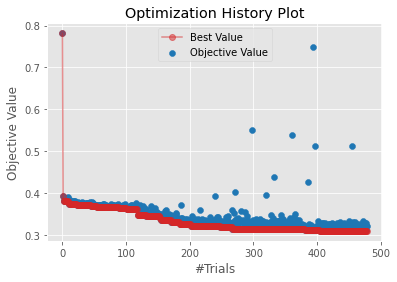

In [146]:
optuna.visualization.matplotlib.plot_optimization_history(study);

In [147]:
study.best_value, study.best_params

(0.3090506102670145,
 {'max_depth': 3,
  'min_child_weight': 4,
  'gamma': 0.044,
  'max_delta_step': 2,
  'colsample_bytree': 0.30000000000000004,
  'subsample': 0.75,
  'reg_alpha': 0.6930000000000001,
  'reg_lambda': 4.798,
  'learning_rate': 0.04365214860451398,
  'n_estimators': 475})

In [171]:
# Pass additional arguments inside another function
func = lambda trial: objective(trial, X, y, cv=kfolds, scoring="neg_mean_squared_error")


study.optimize(func, timeout=60*10, show_progress_bar =True)

# print(f"Base RMSE     : {rmse:.5f}")
print(f"Optimized RMSE: {study.best_value:.5f}")

0it [00:00, ?it/s]

Optimized RMSE: 0.30905


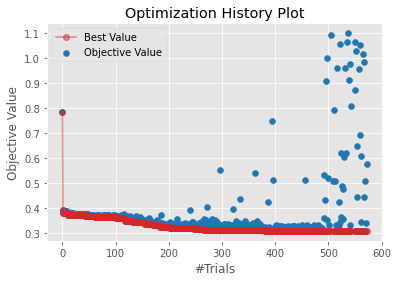

In [172]:
optuna.visualization.matplotlib.plot_optimization_history(study);

In [173]:
study.best_value, study.best_params

(0.3090506102670145,
 {'max_depth': 3,
  'min_child_weight': 4,
  'gamma': 0.044,
  'max_delta_step': 2,
  'colsample_bytree': 0.30000000000000004,
  'subsample': 0.75,
  'reg_alpha': 0.6930000000000001,
  'reg_lambda': 4.798,
  'learning_rate': 0.04365214860451398,
  'n_estimators': 475})

#### BAYES
 -search_xgbr.best_score_, np.sqrt(-search_xgbr.best_score_)
 
(0.0979280089370345, 0.3129345122178672)

 dict(search_xgbr.best_params_)
 
{'colsample_bytree': 0.3548862192798395,
 'gamma': 0.0,
 'learning_rate': 0.03947699668135632,
 'max_delta_step': 5,
 'max_depth': 23,
 'min_child_weight': 9,
 'n_estimators': 1024,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.5}


#### OPTUNA
study_xgbr.best_value, study_xgbr.best_params

(0.3045265635236234,
 {'colsample_bytree': 0.25,
  'gamma': 0.001,
  'learning_rate': 0.02202035690613944,
  'max_delta_step': 3,
  'max_depth': 3,
  'min_child_weight': 8,
  'n_estimators': 875,
  'reg_alpha': 0.5630000000000001,
  'reg_lambda': 3.678,
  'subsample': 0.75})
  
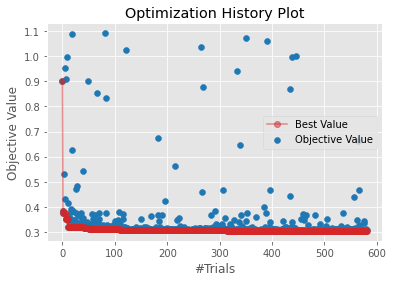

In [93]:
params_xgbr_bayes = {
     'colsample_bytree': 0.3548862192798395,
     'gamma': 0.0,
     'learning_rate': 0.03947699668135632,
     'max_delta_step': 5,
     'max_depth': 23,
     'min_child_weight': 9,
     'n_estimators': 1024,
     'reg_alpha': 0.0,
     'reg_lambda': 0.0,
     'subsample': 0.5
}


params_xgbr_optuna = {
    'max_depth': 3,
  'min_child_weight': 4,
  'gamma': 0.044,
  'max_delta_step': 2,
  'colsample_bytree': 0.3,
  'subsample': 0.75,
  'reg_alpha': 0.693,
  'reg_lambda': 4.798,
  'learning_rate': 0.044,
  'n_estimators': 500
}


base_xgbr_booster = xgb.XGBRegressor()

tuned_xgbr_booster_bayes = xgb.XGBRegressor(**params_xgbr_bayes, eval_metric='rmse')

tuned_xgbr_booster_optuna = xgb.XGBRegressor(**params_xgbr_optuna, eval_metric='rmse')

In [94]:
## BASE

rmse_base_xgbr_booster, mae_base_xgbr_booster, r2_base_xgbr_booster = cv_rmse(base_xgbr_booster, X, y)
display_cv_scores(rmse_base_xgbr_booster, mae_base_xgbr_booster, r2_base_xgbr_booster)

RMSE CV: [0.37217331 0.36705065 0.37461612 0.35171819 0.39630166 0.37565098]  Mean RMSE: 0.3729185 Std RMSE: 0.0131755
MAE CV: [0.25395876 0.25683498 0.25731089 0.25367309 0.27991269 0.25754573]  Mean MAE: 0.2598727 Std MAE: 0.0090941
R2 CV: [0.84321321 0.87970012 0.85574199 0.87344126 0.85168144 0.8498968 ]  Mean R2: 0.8589458 Std R2: 0.0131231


In [95]:
## BAYES

rmse_tuned_xgbr_booster_bayes, mae_tuned_xgbr_booster_bayes, r2_tuned_xgbr_booster_bayes = cv_rmse(tuned_xgbr_booster_bayes, 
                                                                                                      X, y)
display_cv_scores(rmse_tuned_xgbr_booster_bayes, mae_tuned_xgbr_booster_bayes, r2_tuned_xgbr_booster_bayes)

RMSE CV: [0.31707715 0.29288039 0.3215619  0.31484674 0.32497068 0.31603741]  Mean RMSE: 0.3145624 Std RMSE: 0.0102958
MAE CV: [0.2237736  0.21213722 0.21882931 0.22011677 0.2313492  0.22265363]  Mean MAE: 0.2214766 Std MAE: 0.0057765
R2 CV: [0.88619826 0.92340617 0.89370908 0.8985853  0.90026857 0.8937576 ]  Mean R2: 0.8993208 Std R2: 0.0116632


In [96]:
## OPTUNA

rmse_tuned_xgbr_booster_optuna, mae_tuned_xgbr_booster_optuna, r2_tuned_xgbr_booster_optuna = cv_rmse(tuned_xgbr_booster_optuna, 
                                                                                                      X, y)
display_cv_scores(rmse_tuned_xgbr_booster_optuna, mae_tuned_xgbr_booster_optuna, r2_tuned_xgbr_booster_optuna)

RMSE CV: [0.31407705 0.28005    0.32237648 0.29848934 0.31968095 0.31153793]  Mean RMSE: 0.307702 Std RMSE: 0.0145126
MAE CV: [0.21680737 0.20483974 0.20934554 0.20973705 0.22233956 0.21254895]  Mean MAE: 0.212603 Std MAE: 0.0056506
R2 CV: [0.88834159 0.92996997 0.89316988 0.90884927 0.90348891 0.89676124]  Mean R2: 0.9034301 Std R2: 0.0136085


In [69]:
# xgbreg = xgb.XGBRegressor()
# param_distributions = {
#     "max_depth": optuna.distributions.IntUniformDistribution(3, 9),
#         'min_child_weight': optuna.distributions.IntUniformDistribution(1, 9),
#         'gamma': optuna.distributions.DiscreteUniformDistribution(0., 5, 0.001),
#         'max_delta_step': optuna.distributions.IntUniformDistribution(-5, 5),
#         'colsample_bytree': optuna.distributions.DiscreteUniformDistribution(0., 1., 0.05),
#         'subsample': optuna.distributions.DiscreteUniformDistribution(0.5, 1., 0.05),
#         'reg_alpha':  optuna.distributions.DiscreteUniformDistribution(0., 10., 0.001),
#         'reg_lambda': optuna.distributions.DiscreteUniformDistribution(0., 10., 0.001),
#         'learning_rate': optuna.distributions.LogUniformDistribution(0.0001, 0.8),
#         'n_estimators': optuna.distributions.IntUniformDistribution(50, 900, step=25)
# }
# optuna_search = optuna.integration.OptunaSearchCV(
#     xgbreg,
#     param_distributions,
#     cv=kfolds,
#     n_trials=10,
#     random_state=42,
#     verbose=5
    
# )
# optuna_search.fit(X, y) 

# optuna_search.best_params_, optuna_search.best_score_

### LightGBM Regressor

##### Select boosting type

In [14]:
param_lgbm1 = {
    'boosting_type': ['gbdt', 'dart', 'goss', 'rf'] 
}
gridsearch_lgbm1 = GridSearchCV(estimator=lgb.LGBMRegressor(),
                          param_grid= param_lgbm1,
                          scoring='neg_mean_squared_error',
                          cv=kfolds,
                               verbose=2)

gridsearch_lgbm1 = gridsearch_lgbm1.fit(X, y)

Fitting 6 folds for each of 4 candidates, totalling 24 fits
[CV] END .................................boosting_type=gbdt; total time=   0.4s
[CV] END .................................boosting_type=gbdt; total time=   0.4s
[CV] END .................................boosting_type=gbdt; total time=   0.4s
[CV] END .................................boosting_type=gbdt; total time=   0.4s
[CV] END .................................boosting_type=gbdt; total time=   0.3s
[CV] END .................................boosting_type=gbdt; total time=   0.4s
[CV] END .................................boosting_type=dart; total time=   0.4s
[CV] END .................................boosting_type=dart; total time=   0.4s
[CV] END .................................boosting_type=dart; total time=   0.5s
[CV] END .................................boosting_type=dart; total time=   0.5s
[CV] END .................................boosting_type=dart; total time=   0.4s
[CV] END .................................boostin

In [15]:
gridsearch_lgbm1.best_params_, -gridsearch_lgbm1.best_score_

({'boosting_type': 'gbdt'}, 0.11322520468394047)

In [16]:
best_params_lgbm = gridsearch_lgbm1.best_params_
best_params_lgbm, -gridsearch_lgbm1.best_score_

({'boosting_type': 'gbdt'}, 0.11322520468394047)

###### RandomizeSearch

In [69]:


# rand_search_params= {
#     'n_estimators': np.linspace(100, 10000, 100, dtype=int),
#     'learning_rate': np.logspace(np.log10(0.001), np.log10(0.5), base = 10, num = 100),
#     'min_gain_to_split': np.arange(0, 1, 0.05),
#     'num_leaves': np.arange(10, 250),
#     'max_depth': np.arange(2, 25),
#     'max_bin': np.arange(5, 50),
#     'min_child_samples':  np.arange(2, 50),
#     'reg_alpha': np.linspace(0, 1, 100),
#     'reg_lambda': np.linspace(0, 1, 100),
#     'subsample': np.arange(0.5, 1., 0.1),
#     'subsample_freq' : [4,5,7,10], 
#     'bagging_seed': [4,5,7,10],
#     'feature_fraction_seed': [4,5,7,10],
#     'feature_fraction': np.arange(0.5, 1., 0.1)

# }

# gridsearch_lgbm_rand = RandomizedSearchCV(estimator=lgb.LGBMRegressor(**best_params_lgbm, early_stopping_rounds=30),
#                           param_distributions = rand_search_params,
#                           scoring='neg_mean_squared_error',
#                           cv=kfolds,
#                           verbose=2)

# gridsearch_lgbm_rand.fit(X, y)


##### BayesSearch

In [59]:
# https://neptune.ai/blog/lightgbm-parameters-guide

param_lgbm2 = {
    'n_estimators': np.linspace(100, 10000, 100, dtype=int),
    'learning_rate': np.logspace(np.log10(0.001), np.log10(0.5), base = 10, num = 100),
    'min_gain_to_split': np.arange(0, 1, 0.05),
    'num_leaves': np.arange(10, 250),
    'max_depth': np.arange(2, 25),
    'max_bin': np.arange(5, 50),
    'min_child_samples':  np.arange(2, 50),
    'reg_alpha': np.linspace(0, 1, 100),
    'reg_lambda': np.linspace(0, 1, 100),
    'subsample': np.arange(0.5, 1., 0.1),
    'subsample_freq' : [4,5,7,10], 
    'bagging_seed': [4,5,7,10],
    'feature_fraction_seed': [4,5,7,10],
    'feature_fraction': np.arange(0.5, 1., 0.1)
}


gridsearch_lgbm2 = skopt.BayesSearchCV(estimator=lgb.LGBMRegressor(**best_params_lgbm, silent=True, ),
                          search_spaces = param_lgbm2,
                          scoring='neg_mean_squared_error',
                          cv=kfolds,
                          verbose=3,
                          n_jobs=6,
                          n_iter=100,
                          random_state=42)

gridsearch_lgbm2_ = gridsearch_lgbm2.fit(X, y)

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

In [61]:
gridsearch_lgbm2_

BayesSearchCV(cv=KFold(n_splits=6, random_state=42, shuffle=True),
              estimator=LGBMRegressor(), n_iter=100, n_jobs=6, random_state=42,
              scoring='neg_mean_squared_error',
              search_spaces={'bagging_seed': [4, 5, 7, 10],
                             'feature_fraction': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                             'feature_fraction_seed': [4, 5, 7, 10],
                             'learning_rate': array([0.001     , 0.00106479, 0.00113377, 0.00120722, 0.001...
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747475,
       0.75757576, 0.76767677, 0.77777778, 0.78787879, 0.7979798 ,
       0.80808081, 0.81818182, 0.82828283, 0.83838384, 0.84848485,
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ]),
                             'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9]),
   

In [60]:
-gridsearch_lgbm2.best_score_

0.09781439559236388

In [176]:
np.sqrt(0.09781439559236388)

0.31275293058956916

In [62]:
gridsearch_lgbm2.best_estimator_

LGBMRegressor(bagging_seed=7, feature_fraction=0.5, feature_fraction_seed=10,
              learning_rate=0.011567262938827608, max_bin=41, max_depth=7,
              min_child_samples=19, min_gain_to_split=0.05, n_estimators=10000,
              num_leaves=213, reg_alpha=0.4444444444444445,
              reg_lambda=0.8080808080808082, subsample=0.7, subsample_freq=7)

In [63]:
dict(gridsearch_lgbm2.best_params_)

{'bagging_seed': 7,
 'feature_fraction': 0.5,
 'feature_fraction_seed': 10,
 'learning_rate': 0.011567262938827608,
 'max_bin': 41,
 'max_depth': 7,
 'min_child_samples': 19,
 'min_gain_to_split': 0.05,
 'n_estimators': 10000,
 'num_leaves': 213,
 'reg_alpha': 0.4444444444444445,
 'reg_lambda': 0.8080808080808082,
 'subsample': 0.7,
 'subsample_freq': 7}

In [68]:
rmse_gridsearch_lgbm2_, mae_gridsearch_lgbm2_, r2_gridsearch_lgbm2_ = cv_rmse(lgb.LGBMRegressor(**dict(gridsearch_lgbm2.best_params_, 
                                                                                                      silent=True,)), X, y)
display_cv_scores(rmse_gridsearch_lgbm2_, mae_gridsearch_lgbm2_, r2_gridsearch_lgbm2_)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05


In [70]:
best_params_lgbm.update(gridsearch_lgbm2.best_params_)
best_params_lgbm, -gridsearch_lgbm2.best_score_

({'boosting_type': 'gbdt',
  'bagging_seed': 7,
  'feature_fraction': 0.5,
  'feature_fraction_seed': 10,
  'learning_rate': 0.011567262938827608,
  'max_bin': 41,
  'max_depth': 7,
  'min_child_samples': 19,
  'min_gain_to_split': 0.05,
  'n_estimators': 10000,
  'num_leaves': 213,
  'reg_alpha': 0.4444444444444445,
  'reg_lambda': 0.8080808080808082,
  'subsample': 0.7,
  'subsample_freq': 7},
 0.09781439559236388)

#### Optuna

In [82]:
def objective_lgbm(trial, X, y, cv, scoring):
    params = {
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int("n_estimators", 100, 10000, step=25),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.3),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 1, step= 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'max_bin': trial.suggest_int('max_bin', 5, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0., 5., step=0.001),
        'reg_lambda': trial.suggest_float('reg_lambda', 0., 5., step=0.001),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9999, step=0.001),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 15),
        'bagging_seed': trial.suggest_int('bagging_seed', 0, 15),
        'feature_fraction_seed': trial.suggest_int('feature_fraction_seed', 0, 15),
        'feature_fraction': trial.suggest_float('subsample', 0.5, 0.9999, step=0.001)
    }
    
    gr_reg = lgb.LGBMRegressor(**params)
    scores = cross_validate(gr_reg, X, y, cv=cv, scoring=scoring, n_jobs=2)
    
    rmse = np.sqrt(-scores["test_score"].mean())

    return rmse

In [178]:
%%time

sampler_lgbm = optuna.samplers.CmaEsSampler(seed=7)
# sampler = optuna.samplers.NSGAIISampler()
# sampler = optuna.samplers.RandomSampler(seed=7)

# Create study that minimizes
study_lgbm = optuna.create_study(direction="minimize", sampler=sampler_lgbm) #, sampler=sampler

# Pass additional arguments inside another function
func_lgbm = lambda trial: objective_lgbm(trial, X, y, cv=kfolds, scoring="neg_mean_squared_error")


study_lgbm.optimize(func_lgbm, timeout=60*110, show_progress_bar =True)

# print(f"Base RMSE     : {rmse:.5f}")
print(f"Optimized RMSE: {study_lgbm.best_value:.5f}")

0it [00:00, ?it/s]

Optimized RMSE: 0.31248
Wall time: 1h 50min 4s


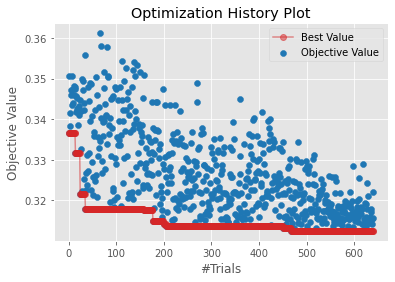

In [179]:
optuna.visualization.matplotlib.plot_optimization_history(study_lgbm);

In [180]:
study_lgbm.best_value, study_lgbm.best_params

(0.3124794834480935,
 {'n_estimators': 5050,
  'learning_rate': 0.013246225789170006,
  'min_gain_to_split': 0.1,
  'num_leaves': 52,
  'max_depth': 13,
  'max_bin': 28,
  'min_child_samples': 26,
  'reg_alpha': 0.153,
  'reg_lambda': 4.4750000000000005,
  'subsample': 0.61,
  'subsample_freq': 5,
  'bagging_seed': 8,
  'feature_fraction_seed': 4})

In [86]:
%%time

# sampler_lgbm = optuna.samplers.CmaEsSampler(seed=7)
# sampler = optuna.samplers.NSGAIISampler()
# sampler = optuna.samplers.RandomSampler(seed=7)

# Create study that minimizes
study_lgbm = optuna.create_study(direction="minimize", sampler=sampler_lgbm) #, sampler=sampler

# Pass additional arguments inside another function
func_lgbm = lambda trial: objective_lgbm(trial, X, y, cv=kfolds, scoring="neg_mean_squared_error")


study_lgbm.optimize(func_lgbm, timeout=60*60*3, show_progress_bar =True)

# print(f"Base RMSE     : {rmse:.5f}")
print(f"Optimized RMSE: {study_lgbm.best_value:.5f}")

0it [00:00, ?it/s]

Optimized RMSE: 0.31087
Wall time: 3h 3s


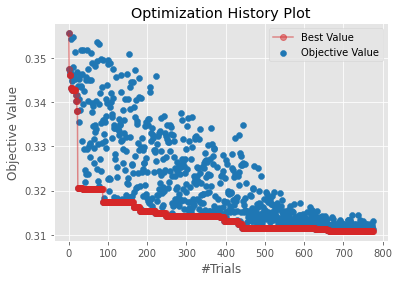

In [87]:
optuna.visualization.matplotlib.plot_optimization_history(study_lgbm);

In [88]:
study_lgbm.best_value, study_lgbm.best_params

(0.31086762747269037,
 {'n_estimators': 5050,
  'learning_rate': 0.004848581842511997,
  'min_gain_to_split': 0.0,
  'num_leaves': 53,
  'max_depth': 11,
  'max_bin': 28,
  'min_child_samples': 27,
  'reg_alpha': 0.053,
  'reg_lambda': 2.251,
  'subsample': 0.616,
  'subsample_freq': 7,
  'bagging_seed': 7,
  'feature_fraction_seed': 8})

#### BAYES

-search_lgbm_.best_score_, np.sqrt(-search_lgbm_.best_score_)

(0.09446497342138672, 0.3073515469643625)

dict(search_lgbm_.best_params_)

{'bagging_seed': 11,
 'feature_fraction': 0.5,
 'feature_fraction_seed': 12,
 'learning_rate': 0.004013138203882341,
 'max_bin': 50,
 'max_depth': 2,
 'min_child_samples': 2,
 'min_gain_to_split': 0.0,
 'n_estimators': 9534,
 'num_leaves': 10,
 'reg_alpha': 1.0,
 'reg_lambda': 0.0,
 'subsample': 0.557334026744272,
 'subsample_freq': 2}


#### OPTUNA

study_lgbm.best_value, study_lgbm.best_params

(0.31086762747269037,
 {'n_estimators': 5050,
  'learning_rate': 0.004848581842511997,
  'min_gain_to_split': 0.0,
  'num_leaves': 53,
  'max_depth': 11,
  'max_bin': 28,
  'min_child_samples': 27,
  'reg_alpha': 0.053,
  'reg_lambda': 2.251,
  'subsample': 0.616,
  'subsample_freq': 7,
  'bagging_seed': 7,
  'feature_fraction_seed': 8})
  
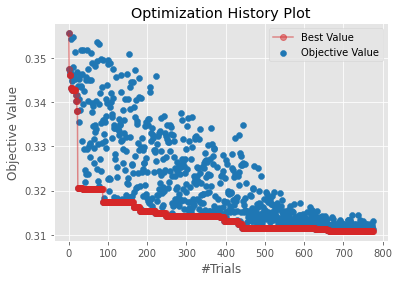

In [110]:
params_lgbm_bayes = {
     'bagging_seed': 11,
     'feature_fraction': 0.5,
     'feature_fraction_seed': 12,
     'learning_rate': 0.004013138203882341,
     'max_bin': 50,
     'max_depth': 2,
     'min_child_samples': 2,
     'min_gain_to_split': 0.0,
     'n_estimators': 9534,
     'num_leaves': 10,
     'reg_alpha': 1.0,
     'reg_lambda': 0.0,
     'subsample': 0.557334026744272,
     'subsample_freq': 2,
     'silent': True
}


params_lgbm_optuna = {
      'n_estimators': 5050,
      'learning_rate': 0.004848581842511997,
      'min_gain_to_split': 0.0,
      'num_leaves': 53,
      'max_depth': 11,
      'max_bin': 28,
      'min_child_samples': 27,
      'reg_alpha': 0.053,
      'reg_lambda': 2.251,
      'subsample': 0.616,
      'subsample_freq': 7,
      'bagging_seed': 7,
      'feature_fraction_seed': 8
}

base_lgbm_booster = lgb.LGBMRegressor()

tuned_lgbm_booster_bayes = lgb.LGBMRegressor(**params_lgbm_bayes)

tuned_lgbm_booster_optuna = lgb.LGBMRegressor(**params_lgbm_optuna, verbose=-1)

In [98]:
## BASE

rmse_base_lgbm_booster, mae_base_lgbm_booster, r2_base_lgbm_booster = cv_rmse(base_lgbm_booster, X, y)
display_cv_scores(rmse_base_lgbm_booster, mae_base_lgbm_booster, r2_base_lgbm_booster)

RMSE CV: [0.34448026 0.32455455 0.32913793 0.32957013 0.35518478 0.33502902]  Mean RMSE: 0.3363261 Std RMSE: 0.0104857
MAE CV: [0.24517961 0.22747823 0.21656203 0.22935602 0.24960427 0.24326186]  Mean MAE: 0.2352403 Std MAE: 0.011642
R2 CV: [0.86567783 0.90594354 0.88864163 0.88887848 0.88086143 0.8806051 ]  Mean R2: 0.8851013 Std R2: 0.0120876


In [111]:
## BAYES

rmse_tuned_lgbm_booster_bayes, mae_tuned_lgbm_booster_bayes, r2_tuned_lgbm_booster_bayes = cv_rmse(tuned_lgbm_booster_bayes, 
                                                                                                   X, y)
display_cv_scores(rmse_tuned_lgbm_booster_bayes, mae_tuned_lgbm_booster_bayes, r2_tuned_lgbm_booster_bayes)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGB

In [112]:
## OPTUNA

rmse_tuned_lgbm_booster_optuna, mae_tuned_lgbm_booster_optuna, r2_tuned_lgbm_booster_optuna = cv_rmse(tuned_lgbm_booster_optuna,
                                                                                                      X, y)
display_cv_scores(rmse_tuned_lgbm_booster_optuna, mae_tuned_lgbm_booster_optuna, r2_tuned_lgbm_booster_optuna)

[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGB

### GradientBoostingRegressor

In [22]:
1/X.shape[0]

0.0007987220447284345

#### BayesSearch

In [89]:
%%time

gbr_params = {
    'loss': ['huber'],
    'learning_rate': Real(0.0001, 0.3, prior='log-uniform'),        
    'n_estimators': Integer(25, 1500, prior='uniform'),
    'subsample':  Real(0.6, 1., prior='uniform'),   
    'max_depth': Integer(1, 23, prior='uniform'),
    'min_samples_split': Real(0.00015, 0.4, prior='uniform'),
    'min_samples_leaf': Real(0.0007, 0.03, prior='uniform'),
    'max_features': Real(0.01, 1., prior='uniform')
}

search_gbr = skopt.BayesSearchCV(estimator=GradientBoostingRegressor(),
                                search_spaces=gbr_params,
                                scoring='neg_mean_squared_error',
                                n_iter=600,
                                cv=kfolds,
                                random_state=11,
                                n_jobs=3,
                                 verbose=10
                                )

search_gbr_ = search_gbr.fit(X, y)

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

KeyboardInterrupt: 

In [92]:
-search_gbr.best_score_, np.sqrt(-search_gbr.best_score_)

In [ ]:
dict(search_gbr.best_params_)

In [ ]:
time.sleep(60*5)

#### Optuna

In [ ]:
def objective_gbr(trial, X, y, cv, scoring):
    params = {
        
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.3),        
        'n_estimators': trial.suggest_int("n_estimators", 25, 1500, step=25),
        'max_depth': trial.suggest_int('max_depth', 1, 35),
        'min_samples_split': trial.suggest_float("min_samples_split", 0.01, 1., step=0.1),
        'min_samples_leaf': trial.suggest_float("min_samples_leaf", 0.1, 5., step=0.1),
        'max_features': trial.suggest_float("min_samples_leaf", 0.01, 1., step=0.01),
        
    }
    
    gr_reg = GradientBoostingRegressor(**params, loss='huber')
    scores = cross_validate(gr_reg, X, y, cv=cv, scoring=scoring, n_jobs=2)
    
    rmse = np.sqrt(-scores["test_score"].mean())

    return rmse

In [ ]:
%%time

# sampler_gbr = optuna.samplers.CmaEsSampler(seed=5)
# sampler = optuna.samplers.NSGAIISampler()
# sampler_gbr = optuna.samplers.RandomSampler(seed=7)

# Create study that minimizes
study_gbr = optuna.create_study(direction="minimize") #, sampler=sampler

# Pass additional arguments inside another function
func_gbr = lambda trial: objective_gbr(trial, X, y, cv=kfolds, scoring="neg_mean_squared_error")


study_gbr.optimize(func_gbr, timeout=60*60*3, show_progress_bar =True)

# print(f"Base RMSE     : {rmse:.5f}")
print(f"Optimized RMSE: {study_gbr.best_value:.5f}")

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study_gbr);

In [ ]:
study_gbr.best_value, study_gbr.best_params

In [ ]:
params_gbr = {
    'n_estimators': 5050,
  'learning_rate': 0.013246225789170006,
  'min_gain_to_split': 0.1,
  'num_leaves': 52,
  'max_depth': 13,
  'max_bin': 28,
  'min_child_samples': 26,
  'reg_alpha': 0.153,
  'reg_lambda': 4.4750000000000005,
  'subsample': 0.61,
  'subsample_freq': 5,
  'bagging_seed': 8,
  'feature_fraction_seed': 4
}

tuned_gbr_booster = GradientBoostingRegressor(**params_gbr)

#### BAYES

-search_gbr.best_score_, np.sqrt(-search_gbr.best_score_)

(0.09074316234536499, 0.30123605751198673)

dict(search_gbr.best_params_)

{'learning_rate': 0.0440214178426571,
 'loss': 'huber',
 'max_depth': 4,
 'max_features': 0.5750332565203448,
 'min_samples_leaf': 0.003217809894833784,
 'min_samples_split': 0.3540291457373217,
 'n_estimators': 727,
 'subsample': 0.7757691666432391}

#### OPTUNA

study_gbr.best_value, study_gbr.best_params

(0.33657088548453534,
 {'learning_rate': 0.06627912441656152,
  'max_depth': 4,
  'max_features': 0.4,
  'min_samples_leaf': 0.1,
  'min_samples_split': 0.21000000000000002,
  'n_estimators': 475})
  
  
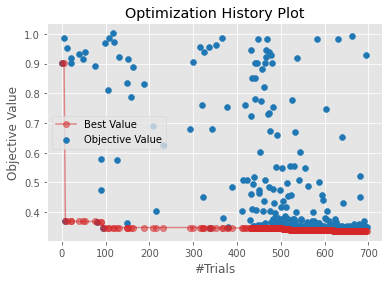


In [113]:
params_gbr_bayes = {
     'learning_rate': 0.044,
     'loss': 'huber',
     'max_depth': 4,
     'max_features': 0.575,
     'min_samples_leaf': 0.003218,
     'min_samples_split': 0.3540,
     'n_estimators': 727,
     'subsample': 0.7758
}

params_gbr_optuna = {
      'learning_rate': 0.06627912441656152,
      'max_depth': 4,
      'max_features': 0.4,
      'min_samples_leaf': 0.1,
      'min_samples_split': 0.21000000000000002,
      'n_estimators': 475
    }

base_gbr_booster = GradientBoostingRegressor()

tuned_gbr_booster_bayes = GradientBoostingRegressor(**params_gbr_bayes)

tuned_gbr_booster_optuna = GradientBoostingRegressor(**params_gbr_optuna)

In [114]:
## BASE

rmse_base_gbr_booster, mae_base_gbr_booster, r2_base_gbr_booster = cv_rmse(base_gbr_booster, X, y)
display_cv_scores(rmse_base_gbr_booster, mae_base_gbr_booster, r2_base_gbr_booster)

RMSE CV: [0.32379716 0.30893973 0.34152062 0.31199628 0.33521631 0.33802525]  Mean RMSE: 0.3265826 Std RMSE: 0.0126518
MAE CV: [0.228729   0.22051481 0.23269596 0.22637278 0.23595376 0.23986619]  Mean MAE: 0.2306887 Std MAE: 0.0063502
R2 CV: [0.88434648 0.91518213 0.87988219 0.89962604 0.89612948 0.87871828]  Mean R2: 0.8923141 Std R2: 0.0128702


In [115]:
## BAYES

rmse_tuned_gbr_booster_bayes, mae_tuned_gbr_booster_bayes, r2_tuned_gbr_booster_bayes = cv_rmse(tuned_gbr_booster_bayes, 
                                                                                                   X, y)
display_cv_scores(rmse_tuned_gbr_booster_bayes, mae_tuned_gbr_booster_bayes, r2_tuned_gbr_booster_bayes)

RMSE CV: [0.30035963 0.27384128 0.31855399 0.30928373 0.30682785 0.31079822]  Mean RMSE: 0.3032774 Std RMSE: 0.0142221
MAE CV: [0.20992639 0.20096114 0.21125161 0.20347358 0.21456171 0.20673958]  Mean MAE: 0.207819 Std MAE: 0.0046326
R2 CV: [0.89864394 0.93329251 0.89429951 0.9012824  0.91314198 0.88907252]  Mean R2: 0.9049555 Std R2: 0.0146581


In [116]:
## OPTUNA

rmse_tuned_gbr_booster_optuna, mae_tuned_gbr_booster_optuna, r2_tuned_gbr_booster_optuna = cv_rmse(tuned_gbr_booster_optuna,
                                                                                                      X, y)
display_cv_scores(rmse_tuned_gbr_booster_optuna, mae_tuned_gbr_booster_optuna, r2_tuned_gbr_booster_optuna)

RMSE CV: [0.34305346 0.31179284 0.36158349 0.34818438 0.33484985 0.33618974]  Mean RMSE: 0.3392756 Std RMSE: 0.0151421
MAE CV: [0.24483031 0.22424632 0.24933187 0.24267879 0.24099623 0.24596792]  Mean MAE: 0.2413419 Std MAE: 0.0080785
R2 CV: [0.86542936 0.91061619 0.86300055 0.88537138 0.89605206 0.87214738]  Mean R2: 0.8821028 Std R2: 0.0171284


### Compare Models

In [118]:
lightgbm = lgb.LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

rmse_lgbm, mae_lgbm, r2_lgbm = cv_rmse(lightgbm, X, y)
display_cv_scores(rmse_lgbm, mae_lgbm, r2_lgbm )

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

In [169]:
xgboost = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

rmse_xgb, mae_xgb, r2_xgb = cv_rmse(xgboost, X1, y1)
display_cv_scores(rmse_xgb, mae_xgb, r2_xgb)

RMSE CV: [0.23888119 0.22098587 0.2488139  0.24075765 0.24800949 0.25537261]  Mean RMSE: 0.2421368 Std RMSE: 0.0109096
MAE CV: [0.1659052  0.15294113 0.16876011 0.17164554 0.16992981 0.17657041]  Mean MAE: 0.1676254 Std MAE: 0.0073185
R2 CV: [0.89383621 0.92833028 0.89540528 0.90253332 0.90452849 0.88598473]  Mean R2: 0.9017697 Std R2: 0.0133309


In [135]:
rmse_xgb, mae_xgb, r2_xgb = cv_rmse(xgboost, X1, y1)
display_cv_scores(rmse_xgb, mae_xgb, r2_xgb)

RMSE CV: [0.30564225 0.28305718 0.3188826  0.30970968 0.31677962 0.325578  ]  Mean RMSE: 0.3099416 Std RMSE: 0.0136168
MAE CV: [0.21212717 0.19660931 0.21561874 0.22066512 0.21766712 0.22540358]  Mean MAE: 0.2146818 Std MAE: 0.0090709
R2 CV: [0.89425842 0.92845792 0.89547296 0.90186768 0.90523278 0.88724624]  Mean R2: 0.9020893 Std R2: 0.0131063
